# SpatialPPIv2 Colab Usage Example

## 1. Clone SpatialPPIv2 repository

In [2]:
!git clone https://github.com/ohuelab/SpatialPPIv2.git

Cloning into 'SpatialPPIv2'...
remote: Enumerating objects: 112, done.
remote: Counting objects: 100% (55/55), done.
remote: Compressing objects: 100% (43/43), done.
remote: Total 112 (delta 22), reused 31 (delta 10), pack-reused 57 (from 1)
Receiving objects: 100% (112/112), 198.60 MiB | 35.31 MiB/s, done.
Resolving deltas: 100% (34/34), done.
Updating files: 100% (29/29), done.


## 2. Environment preparation

Normally, this will take a few minutes.

In [ ]:
!pip install torch==2.2.1
!pip install torch_geometric==2.5.1
!pip install lightning==2.2.1
!pip install biopandas==0.5.1
!pip install transformers==4.40.2
!pip install sentencepiece==0.2.0
!pip install torchsummary==1.5.1
!pip install torchvision==0.17.1
!pip install scipy==1.12.0
!pip install torch_cluster
!pip install git+https://github.com/yusuf1759/prodigy-cryst.git
!pip install fair-esm
!pip install pinder[all]
!pip install numpy
!pip install pandas
!pip install seaborn
!pip install tensorboard

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 755.6/755.6 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 77.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 100.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 55.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## 3.Inference Protein-Protein Interaction Probability

It will take several minutes to download the protein language model for the first time.

In [3]:
!cd SpatialPPIv2 && python inference.py --A demo/P33895.pdb --B demo/P40460.pdb

Traceback (most recent call last):
  File "/content/SpatialPPIv2/inference.py", line 7, in <module>
    from utils.model import getModel
  File "/content/SpatialPPIv2/utils/model.py", line 2, in <module>
    import torchmetrics
ModuleNotFoundError: No module named 'torchmetrics'


## 4. Visualization of inference process

In [ ]:
# Import packages
import sys
import torch

import numpy as np

from SpatialPPIv2.utils.model import getModel
from SpatialPPIv2.utils.dataset import build_data
from SpatialPPIv2.utils.tool import getConfig, extractPDB, Embed
import SpatialPPIv2.utils.visualize as vis

In [ ]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load embedder
embedder = Embed('Rostlab/prot_t5_xl_uniref50', device)

# Load model
cfg = getConfig('./SpatialPPIv2/config/default.yaml')
cfg['basic']['num_features'] = embedder.featureLen

# set return_attention to True to return attention weights of attention heads
model = getModel(cfg, ckpt='./SpatialPPIv2/checkpoint/SpatialPPIv2_ProtT5.ckpt', return_attention=True).to(device)
model = model.eval()

Initializing protein sequence embedder ... 

INFO: Seed set to 2032
INFO:lightning.fabric.utilities.seed:Seed set to 2032


Done


### Ground truth protein complex P33895-P40460

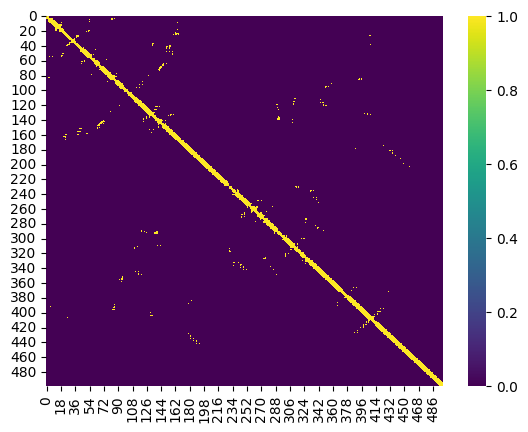

In [ ]:
seq_gt, coord_gt = extractPDB('./SpatialPPIv2/demo/P33895-P40460-gt.pdb', chains=['L', 'R'])
vis.visualize_contact_map(np.concatenate(coord_gt), distance_threshold=8)

### Load input data of network

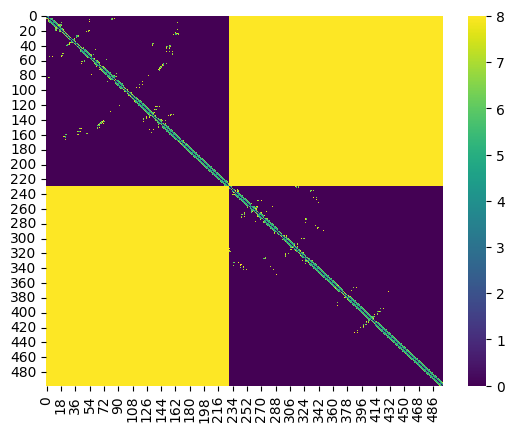

In [ ]:
# Load structure from PDB
seq_a, coord_a = extractPDB('./SpatialPPIv2/demo/P33895-P40460-gt.pdb', chains='L')      # Protein P33895
seq_b, coord_b = extractPDB('./SpatialPPIv2/demo/P33895-P40460-gt.pdb', chains='R')      # Protein P40460

# build input data for the network
input_data = build_data(
    node_feature=torch.cat([embedder.encode(i) for i in [seq_a, seq_b]]),
    coords=[coord_a, coord_b],
)

# Show the input data
vis.visualize_data(input_data)

### Inference sample input data

Predicted prob: 0.9602065086364746


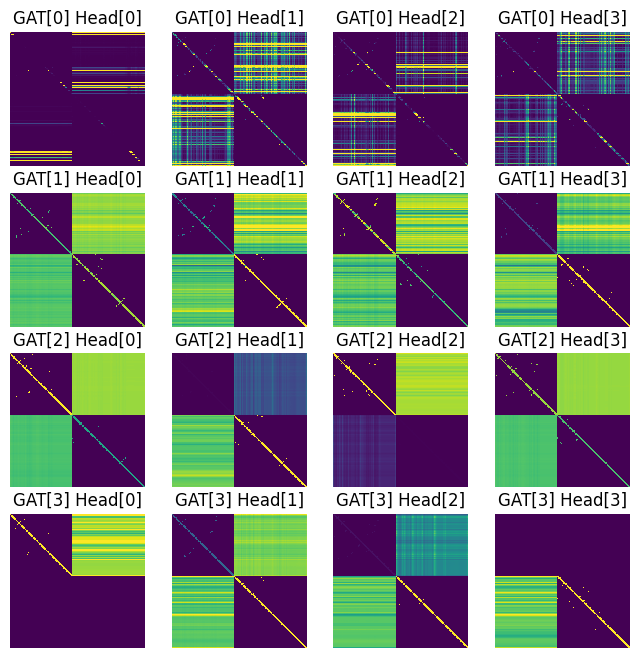

In [ ]:
with torch.no_grad():
    pred, aws = model(input_data.clone().to(device))
print('Predicted prob:', pred.cpu().tolist()[0])

# Visualize attention weights
vis.visualize_attentions(input_data, aws, vmin=0, vmax=0.005)